## Toxic Comment Classification

Tasked with the challenge to predict the labels of text that has been supplied.
First 2 labels: Toxicity & Severe Toxicity.
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

### Initial analysis.

### Steps: 
- Load data
- Basic features (on original dataset)
- Pre-processing (clean up)
- Feature Engineering: explore Clustering/ PCA
- Split test into training & validation sets
- Modeling

In [ ]:
# References:

# http://dsbyprateekg.blogspot.com/2017/12/can-you-build-model-to-predict-toxic.html
# NB: https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/
# https://www.analyticsvidhya.com/blog/2014/11/text-data-cleaning-steps-python/
# https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/

# Notes:
# To understand: do you train on both columns, or all the columns together? Or is it meant to by one or the other?

In [1]:
# Implement Packages

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Download stopwords
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

### Loading & Structure of the Dataset

In [34]:
## Load Data
# Load data into Pandas dataframe

# Load Train Dataset
train = pd.read_csv('data/train.csv')
# train.head()
type(train) # Loaded as Pandas DF
print ('Structure of Train Dataset: ', train.shape)

# Load Test Dataset
test = pd.read_csv('data/test.csv')
# test.head()
print ('Structure of Test Dataset: ', test.shape)

# Load Test Labels Dataset
# test_labels = pd.read_csv('data/test_labels.csv')
# print test_labels.head()
# print ('Structure of Test Labels Dataset: ', test_labels.shape)

# A value of -1 means that it wasn't used for scoring? To understand?

('Structure of Train Dataset: ', (159571, 8))
('Structure of Test Dataset: ', (153164, 2))


In [35]:
# Here I think I should combine train + test = full dataframe 
# (such that test dataset = same number of features as train?)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [48]:
# Understanding if there are any null comments?

train[train['comment_text'].isnull()]
# There are 0 null comments in the train dataset

test[test['comment_text'].isnull()]
# There are 0 null comments in the test dataset


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,word_count,avg_word,mentions,uppercase,stop_words,sentiment


Because we have split our project into 3 distict sections, of which each memeber will take 2 labels to predict/ text classify on. I'll now take the datasets that have been loaded and limit it to my section only.
I'll be predicting on the first 2 labels: Toxic and Severe Toxicity.

To note, we have been supplied with a test_labels dataset that can be used to examine our prediction score & accuracy.
This is suggested as a criteria for determining the best/ most suited model.

In [6]:
# Pulling only my subset of data required (Toxicity)

# Train 
train_t = train.iloc[:, 0:4]
train_t.head()
train_t.shape

# Test
test_t = test.iloc[:, 0:3]
test_t.head()

# train_t.head()

,id,comment_text,toxic,severe_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0


### Basic Feature Extraction

- Number of Words:
It's understood that generally the negative sentiments contain lesser number of words than positive words.
- Number of Stopwords:
Generally, the stopwords are removed. Let's see if this offers any valuable insight. 
- Mentions/ @
Let's see if negative sentiments are generally geared specifically to people, or not.

Worth overlaying these features with clustering?

In [40]:
# cols added to the original train dataset

# Detemrine number of words:
train['word_count'] = train['comment_text'].apply(lambda x: len(str(x).split(" ")))

# Average word length
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

train['avg_word'] = train['comment_text'].apply(lambda x: avg_word(x))

# Caclulating number of stopwords
# Unicode error on stopwords
# stop = stopwords.words("english")
# train['stop_words'] = train['comment_text'].apply(lambda x: len([x for x in x.split() if x in stop]))

# Number of mentions (starts with '#')
train['mentions'] = train['comment_text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

# Number of Uppercases
train['uppercase'] = train['comment_text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

/Users/Gabriella_Camara/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  from ipykernel import kernelapp as app


In [41]:
train[['comment_text', 'word_count', 'avg_word', 'stop_words', 'mentions', 'uppercase', 'toxic', 'severe_toxic']].head()

,comment_text,word_count,avg_word,stop_words,mentions,uppercase,toxic,severe_toxic
0,Explanation\nWhy the edits made under my usern...,42,5,14,0,2,0,0
1,D'aww! He matches this background colour I'm s...,18,5,1,0,1,0,0
2,"Hey man, I'm really not trying to edit war. It...",42,4,18,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",112,4,49,0,5,0,0
4,"You, sir, are my hero. Any chance you remember...",13,4,4,0,0,0,0


In [22]:
from sklearn.cluster import KMeans
kmeans = KMeans()

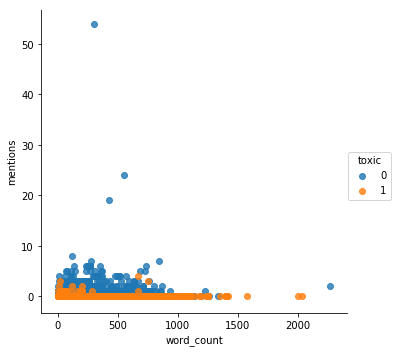

In [35]:
# sns.lmplot('word_count', 'uppercase', data = train, fit_reg = False, hue = 'toxic')
sns.lmplot('word_count', 'mentions', data = train, fit_reg = False, hue = 'toxic')

In [39]:
#train.head()

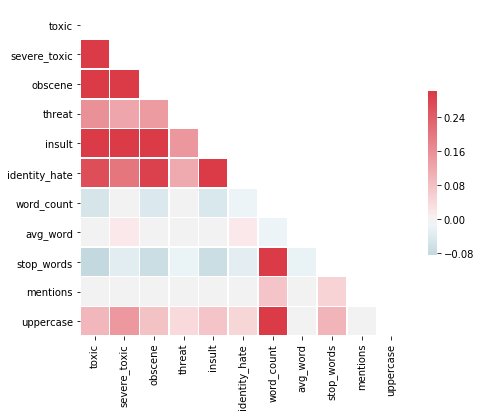

In [38]:
# Perhaps consider a correlation between classifications
# i'm sure this is irrelevant, but i'm interested
x_cor = train.iloc[:, 2:]
corr = x_cor.corr()

corr
# sns.heatmap(corr)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Initial Analysis on the whole dataset
Let's have a closer look at the whole dataset; see if we can derive some insights?

Text(0.5,1,u'Count of Classification')

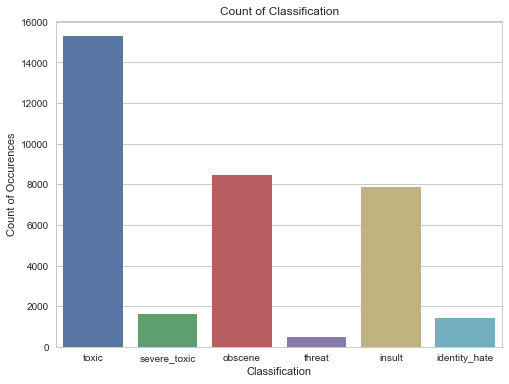

In [41]:
# A count of the number of occurances of the different clasifications

x = train.iloc[:, 2:8].sum() # Only considering the count of the classification, regardless of id/ text

# Barplot (using seaborn)
sns.set(style = 'whitegrid')
ax = sns.barplot(x.index, x.values)
ax.set_xlabel('Classification')
ax.set_ylabel('Count of Occurences')
plt.title('Count of Classification')

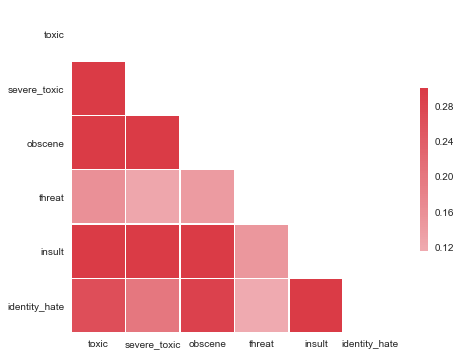

In [42]:
# Perhaps consider a correlation between classifications
# i'm sure this is irrelevant, but i'm interested
x_cor = train.iloc[:, 2:8]
corr = x_cor.corr()

corr
# sns.heatmap(corr)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [13]:
valid_y

array([0, 0, 0, ..., 0, 0, 1])

### Cleaning of Data: Basic Pre-processing
In an effort to clean the data that has been sorced from the internet, let's explore methods of cleaning the data in an effort to improve our accuracy on our predictions.

Efforts to include:
- Escaping HTML characters (remove HTML characters that could be embedded in data)
- Convert to LowerCase
- Remove punctuation
- Remove stopwords
- Lemmatization (return to root word)

Additional thoughts/ efforts:
- APOSTROPHES!
- Remove date & timestamp
- Remove URLs
- Spelling correction

In [42]:
# +- 6 minutes to run - can I make this quicker?
from textblob import Word
import HTMLParser

# Escaping HTML characters: remove HTML characters (from web) which might be embedded in data
html_parser = HTMLParser.HTMLParser()
train['comment_text'] = html_parser.unescape(train['comment_text'])

# Convert to Lower Case
train['comment_text'] = train['comment_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
# Remove punctuation
train['comment_text'] = train['comment_text'].str.replace('[^\w\s]','')
# Remove stopwords
stop = stopwords.words("english")
train['comment_text'] = train['comment_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
# Lemmatization
train['comment_text'] = train['comment_text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

train['comment_text'].head()

0    explanation edits made username hardcore metal...
1    daww match background colour im seemingly stuc...
2    hey man im really trying edit war guy constant...
3    cant make real suggestion improvement wondered...
4                  sir hero chance remember page thats
Name: comment_text, dtype: object

In [ ]:
# There must be an easier way to remove apostrophes?

import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

clean_comment = []
for i in range(0, len(train)):
    cleaned_comment = decontracted(train['comment_text'][i]) 
    clean_comment.append(cleaned_comment)
train['comment_text'] = pd.Series(clean_comment).astype(str)    


### Feature Engineering: Sentiment Analysis

List of added features:
- Sentiments (using TextBlob package)


In [43]:
# Sentiment Analysis
from textblob import TextBlob

train['sentiment'] = train['comment_text'].apply(lambda x: TextBlob(x).sentiment[0])
# polarity implies the sentiment

train.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,word_count,avg_word,mentions,uppercase,stop_words,sentiment
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,42,5,0,2,14,0.136364
1,000103f0d9cfb60f,daww match background colour im seemingly stuc...,0,0,0,0,0,0,18,5,0,1,1,0.200000
2,000113f07ec002fd,hey man im really trying edit war guy constant...,0,0,0,0,0,0,42,4,0,0,18,0.150000
3,0001b41b1c6bb37e,cant make real suggestion improvement wondered...,0,0,0,0,0,0,112,4,0,5,49,0.183333
4,0001d958c54c6e35,sir hero chance remember page thats,0,0,0,0,0,0,13,4,0,0,4,0.000000


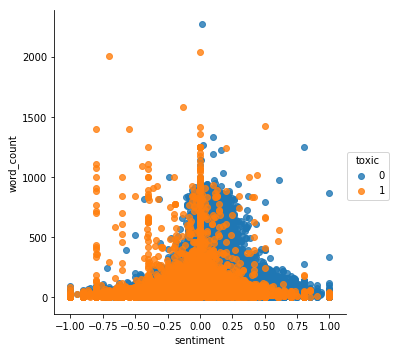

In [57]:
sns.lmplot('sentiment', 'word_count', data = train, fit_reg = False, hue = 'toxic')

### Output of csv file

In [54]:
train[train['comment_text'].isnull()]

train.iloc[2407, :]

id               067638a445ccd93b
comment_text                     
toxic                           0
severe_toxic                    0
obscene                         0
threat                          0
insult                          0
identity_hate                   0
word_count                      4
avg_word                        4
mentions                        0
uppercase                       0
stop_words                      2
sentiment                       0
Name: 2407, dtype: object

In [50]:
train.to_csv('train_engineered.csv', index = False)